In [76]:
import pickle
import datetime
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from scipy.optimize import least_squares

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split

from libs_unet.models import peakyfinder_0001
from libs_unet.training.spec_maker import spectrum_maker

top_dir = Path.cwd()
datapath = top_dir / 'data'

In [116]:
#reference data load
elem_symb = np.loadtxt(datapath / "abundance/elements_94.csv", dtype=str)
#Leverage PyTorch native Dataset and DataLoader 
#Define Train/Test sets from 20 element data samples
with open(datapath / 'training/z20_pairs.pickle', 'rb') as f:
    fracs = pickle.load(f)
    wave = pickle.load(f)
    x_data = pickle.load(f)
    y_data = pickle.load(f)

# set number of elements and wavelengths for this data
max_z = 20
wave = np.arange(190,950)
#create dataset
#input needs a placeholder "channel" dimension since single channel
#learned labels already has max_z + 2 channels from spec_array
#data has to match weights which default to float() so cast data as same
rel_int_scale = 10**4
input_scale = 5
x_data = torch.tensor(x_data[:,None,:].astype('float32'))
y_data = torch.tensor(y_data.astype('float32'))
x_data[x_data < 0] = 0
y_data[y_data < 0] = 0
#log transform data, add small offset 1 so zero points remain ~zero on log scale
x_data = input_scale * torch.log(rel_int_scale * x_data + 1)
y_data = input_scale * torch.log(rel_int_scale * y_data + 1)

#

In [3]:
#Load model and parameters for making predictions
#https://pytorch.org/tutorials/beginner/saving_loading_models.html
model = peakyfinder_0001.LIBSUNet(max_z,len(wave))
param_path = top_dir / 'trained_models' / 'z20_pairs_0001'
model.load_state_dict(torch.load(param_path))


<All keys matched successfully>

sum x: 1.0
H: 0.500000
Cl: 0.500000


/var/folders/q6/v3v7zg9947s0tjqygn5m8l6r0000gn/T/ipykernel_71156/2111320370.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(1, 2)


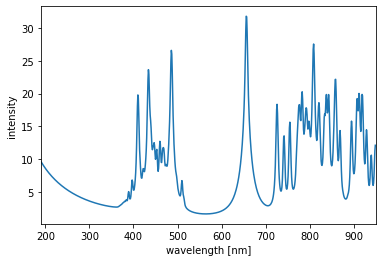

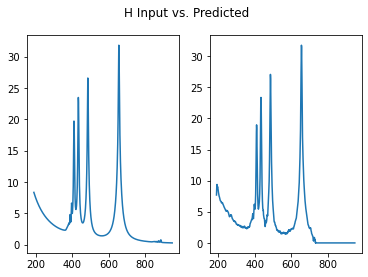

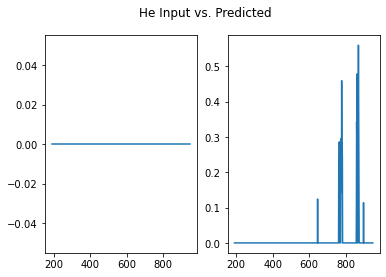

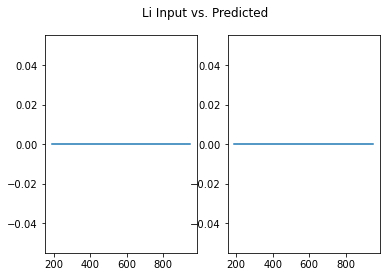

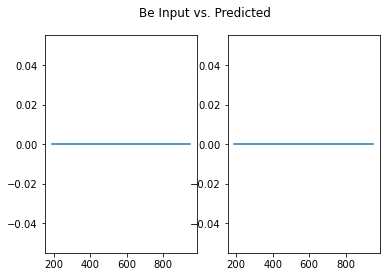

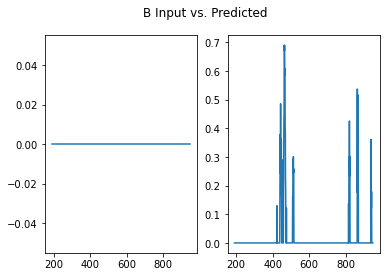

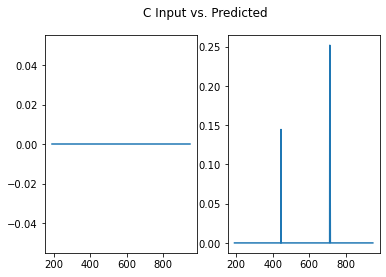

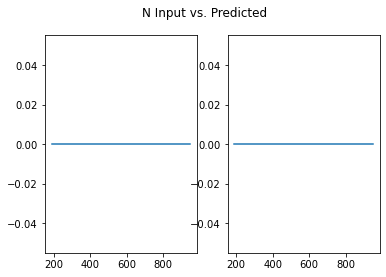

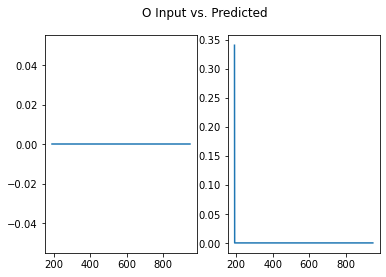

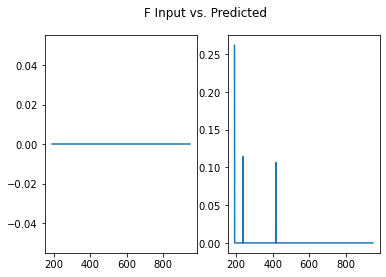

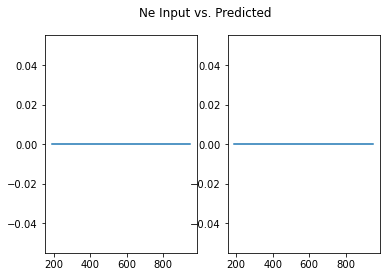

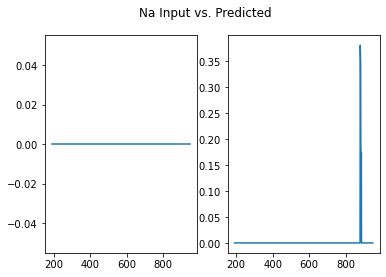

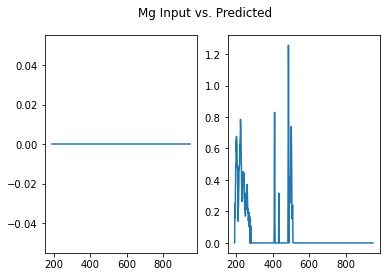

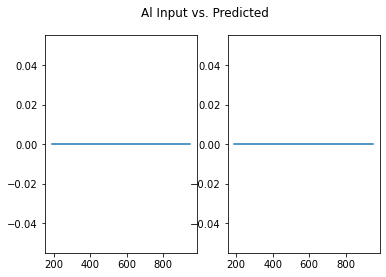

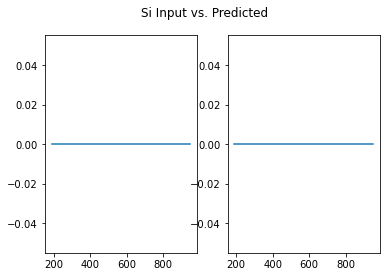

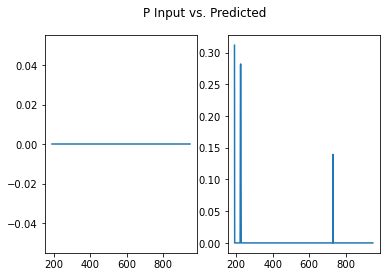

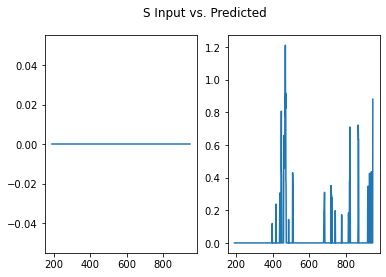

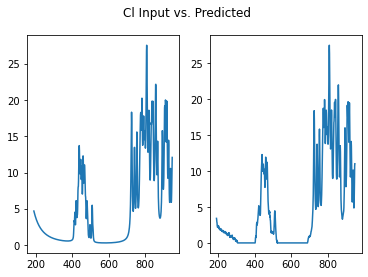

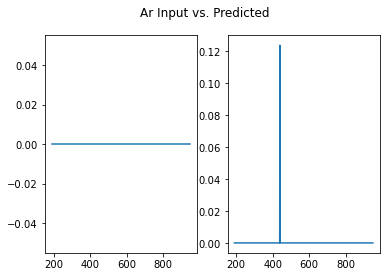

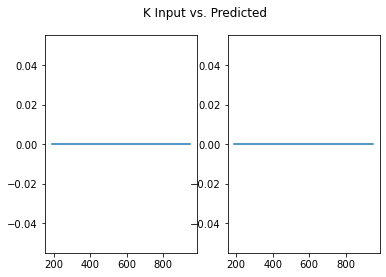

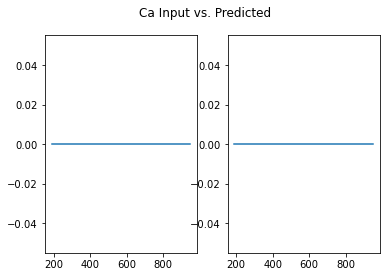

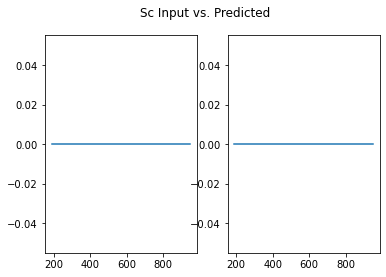

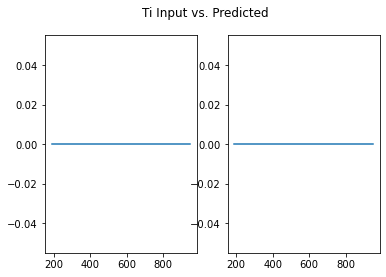

In [4]:
#look at the predicted vs. reference spectra
i_samp = 66 #vary up to 9999
x_sample = x_data[i_samp][None, :, :] #need correct dimensions with batch for prediction
y_sample = y_data[i_samp].detach().numpy() #[22][760] # 20+2 (el + art + noi) spectra

#composite spectra and components
#x_data = input_scale * torch.log(rel_int_scale * x_data + 1)
print(f"sum x: {torch.sum((torch.exp(x_sample[0][0]/input_scale) - 1)/rel_int_scale)}")
#show the element fractions
for i in range(max_z):
    frac = np.sum((np.exp(y_sample[i]/input_scale) - 1)/rel_int_scale)
    if frac > 0:
        print(f"{elem_symb[i]}: {frac:>4f}")
        
#first plot the transformed composite input spectrum we're trying to decompose
plt.plot(wave, x_sample[0][0])
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
plt.xlim([190, 950])
plt.show

#prediction (also transformed at this point)
plot_thresh = 0.1
model.eval()
with torch.no_grad():
    pred = model(x_sample)
    y_pred = pred[0].detach().numpy() #[22][760] corresponding predictions for y_sample
    y_pred[y_pred < plot_thresh] = 0

    #https://matplotlib.org/3.5.0/tutorials/introductory/usage.html#the-object-oriented-interface-and-the-pyplot-interface
    def pred_plot(ax, data1, data2, param_dict):
        out = ax.plot(data1, data2, **param_dict)
        return out
    for i in range(22):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle(f'{elem_symb[i]} Input vs. Predicted ')
        pred_plot(ax1, wave, y_sample[i], {})
        pred_plot(ax2, wave, y_pred[i], {})

In [5]:
print(len(x_data))

590


In [6]:
#Visual inspection indicates that model is picking up the intended elements
#Let's find the threshold that maximizes % samples with correct elemental identification
#We're applying a peak height limit in log space here, so every 2.3 units ~order of mag
model.eval()
with torch.no_grad():
    pred = model(x_data).detach().numpy()

#Boolean array for presence of element for each of 590 samples 
fracs_bool = fracs > 0 #(590, 20)
#Create the same dimension boolean for each prediction at a certain peak threshold (still log space)
#Log whether predicted elements match actual inputs so we can select best cutoff on % match
l_pred = len(pred)
hit_rate = np.zeros(len(range(40)))
cutoff = np.zeros(len(range(40)))
j= 0 #index for threshold accuracy array
for thresh in range(40):
    matches = 0 #track the correct element predictions at this threshold
    for i in range(l_pred):
        match = np.array_equal((np.max(pred[i,0:20,:], axis=1) > thresh), (fracs[i] > 0))
        matches += 1*match
    cutoff[j] = thresh
    hit_rate[j] = matches / l_pred
    j += 1

<function matplotlib.pyplot.show(close=None, block=None)>

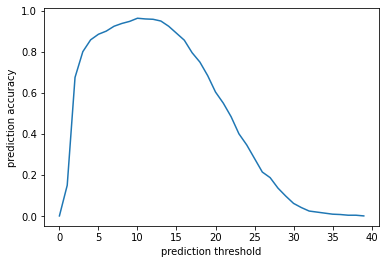

In [7]:
#review prediction accuracy by threshold
plt.plot(cutoff, hit_rate)
plt.xlabel('prediction threshold')
plt.ylabel('prediction accuracy')
plt.show

In [8]:
#which cutoff maximizes element ID accuracy
max_acc_ind = hit_rate.argmax()
print(f"max accuracy: { hit_rate[max_acc_ind]}")
print(f"at threshold: {cutoff[max_acc_ind]}")
#a cutoff of 10 maximizes prediction accuracy, refine within this range to one decimal point

max accuracy: 0.9627118644067797
at threshold: 10.0


In [9]:
hit_rate2 = np.zeros(len(np.arange(9,11,0.1)))
cutoff2 = np.zeros(len(np.arange(9,11,0.1)))
j= 0 #index for threshold accuracy array
for thresh in np.arange(9,11,0.1):
    matches = 0 #track the correct element predictions at this threshold
    for i in range(l_pred):
        match = np.array_equal((np.max(pred[i,0:20,:], axis=1) > thresh), (fracs[i] > 0))
        matches += 1*match
    cutoff2[j] = thresh
    hit_rate2[j] = matches / l_pred
    j += 1

<function matplotlib.pyplot.show(close=None, block=None)>

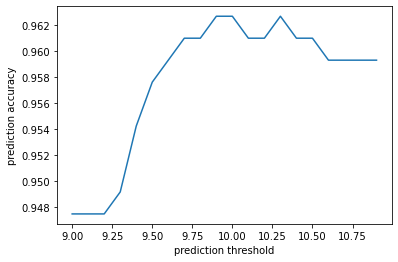

In [10]:
#review prediction accuracy by threshold
plt.plot(cutoff2, hit_rate2)
plt.xlabel('prediction threshold')
plt.ylabel('prediction accuracy')
plt.show

In [111]:
#which cutoff maximizes element ID accuracy
max_acc_ind = hit_rate2.argmax()
print(f"max accuracy: { hit_rate2[max_acc_ind]}")
print(f"at threshold: {cutoff2[max_acc_ind]}")
#no real improvement so we'll stick with 10 for simplicity

max accuracy: 0.9627118644067797
at threshold: 9.899999999999997


In [64]:
#generate reference spectra
spec_maker = spectrum_maker(max_z)

#create array of reference spectra for these 20 elements.
el_spec = np.zeros((20,760))
wave = range(190, 950)
for i in range(20):
    fracs = np.zeros(20)
    fracs[i] = 1
    wave, el_spec[i], spec_array = spec_maker.make_spectra(fracs)
    


In [111]:
type(el_spec)

numpy.ndarray

sum for Li is 1.0


<function matplotlib.pyplot.show(close=None, block=None)>

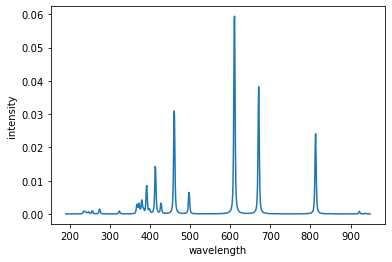

In [65]:
#check spectra
z_el = 3
print(f"sum for {elem_symb[z_el -1]} is {np.sum(el_spec[z_el -1])}")
plt.plot(wave, el_spec[z_el -1])
plt.xlabel('wavelength')
plt.ylabel('intensity')
plt.show

In [68]:
#With a threshold established, identify the predicted elements for each sample
thresh = 10
#define a mask vector with 0,1 values to indicate identified elements   
el_pred = 1*(np.max(pred[:,0:20,:], axis=2) > thresh)

In [135]:
#next task is to find the linear combination of the present spectra that minimizes error to input spectrum
#Try https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html

sample_num = 400 #0-589 , use index for simplicity
input_log = x_data[sample_num].detach().numpy()
#x_data = input_scale * torch.log(rel_int_scale * x_data + 1)
input_spec = (np.exp(input_log / input_scale) - 1) / rel_int_scale

#define the residuals function
def fun_fitspec(x, x_spec, ref_specs):
    return np.squeeze(np.sum((ref_specs.transpose() * x).transpose(), axis=0) - x_spec)
#initial weights as even allocation to identified elements
x0 = el_pred[sample_num] / np.sum(el_pred[sample_num]) #start with balanced allocation to candidates
#add bounds to zero out the non-identified elements
#bounds passed as a 2-tuple of vectors ([lower], [upper]) use np.inf for unbounded
#lower bound for all is non-negative weights
bnd_low = np.zeros(20)
#upper bound on candidates is 1, for which we can use el_pred mask
#need a small delta to avoid lb = ub
bnd_up = el_pred[sample_num] + 0.001
el_bounds = (bnd_low, bnd_up)
#now adjust upper bounds
el_fit = least_squares(fun_fitspec, x0, args=(input_spec, el_spec), bounds=el_bounds)




In [136]:
#review results
fit_wts = el_fit.x.copy()
fit_wts[fit_wts < 0.01] = 0
fit_wts

for i in range(len(fit_wts)):
    print(f"{elem_symb[i]}: ref: {fracs[sample_num][i]} pred: {np.round(fit_wts[i],3)}")

H: ref: 0.0 pred: 0.0
He: ref: 0.0 pred: 0.0
Li: ref: 0.0 pred: 0.0
Be: ref: 0.0 pred: 0.0
B: ref: 0.0 pred: 0.0
C: ref: 0.0 pred: 0.0
N: ref: 0.0 pred: 0.0
O: ref: 0.0 pred: 0.0
F: ref: 0.1 pred: 0.099
Ne: ref: 0.0 pred: 0.0
Na: ref: 0.0 pred: 0.0
Mg: ref: 0.9 pred: 0.933
Al: ref: 0.0 pred: 0.0
Si: ref: 0.0 pred: 0.0
P: ref: 0.0 pred: 0.0
S: ref: 0.0 pred: 0.0
Cl: ref: 0.0 pred: 0.0
Ar: ref: 0.0 pred: 0.0
K: ref: 0.0 pred: 0.0
Ca: ref: 0.0 pred: 0.0


In [109]:
#notes on element-wise array multiplication
x = np.array([1,2,3])
y = np.array(np.ones(12))
y = y.reshape(3,4)
print(x.shape)
print(y.transpose().shape)
print(y)
print(y.transpose())
print((y.transpose()*x).transpose()) #element-wise but need dims to align

(3,)
(4, 3)
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[[1. 1. 1. 1.]
 [2. 2. 2. 2.]
 [3. 3. 3. 3.]]
